This notebook is based on the tutorial in Chapter 10 of the book "Hands-on Machine Learning" by Aurelien Geron.

Highlights of this notebook are:

- **Classifying images and predicting house prices using variations on MLPs**
    - Scale images to 0-1 range
    - There are various ways to build a model using Keras - sequential and subclass APIs are the best.
        - Sequential is simple and easy, subclass is most like pytorch and is more versatile
    - To specify the loss function and optimizer, use the model.compile() method. To train the model, use the model.fit() method. To see the structure of the model, use model.summary().
    - You can directly get the losses by using history = model.fit() and calling history.history.
    - You can save and load the model using model.save("my_keras_model.h5") and model = keras.models.load_model("my_keras_model.h5"). 
    - You can use early stopping by saving only the model with the best val losses: checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True). You can also implement early stopping with  early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True). You can call the model you saved with  history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])
- **Using tensorboard to visualize data during training**
    - Tensorboard is used to visualize loss curves as training occurs. It does this by saving log files (files that log the progress of the task) called event files, and then picking up on changes in the directory where those files are saved. 
    - You should create a root directory (i.e. /logs) and subdirectories for each run, labeled with date and time (/logs/10-01-21_10-36)
    - Tensorboard is used as a callback for your model. You 
    - To open up the tensorboard visualization, go to your root directory in terminal and type tensorboard --logdir=directory/. VERY IMPORTANT: make sure there are no spaces before or after the = sign, otherwise you'll have issues!
- **General Notes, Hyperparameter Training**
    - Though a single layer MLP is a universal approximator, deep networks have much better parameter efficiency - i.e. they can approximate much more complex functions with fewer neurons. Likely due to the fact that hierarchical structures can better capture compositionality.
    - Transfer learning: imagine you train a network to recognize faces. Now you want a network to recognize hairstyles. Instead of building a new network from scratch and randomly initializing weights and biases, you can reuse lower layers of face NN. This is called __```transfer learning```__.
    - Using the same number of neurons per hidden layer generally works well. This is good because then you have fewer hyperparameters to worry about. 
    - One approach is to use more neurons than you think necessary, then early stop/regularize/dropout to prevent overfitting.
    - Batch size of 32 is good. "Friends don't let friends use mini-batches larger than 32" -Yann LeCun 
    - To determine learning rate, start with a large one, enough to make the algorithm converge, and then continually divide by 3 until it no longer diverges. This is your max learning rate. The optimal learning rate, as a rule of thumb, is about 1/2 of the max learning rate. Optimizers like Adam can reduce the learning rate for you.
    
As a side note, Google (and some other companies) offer hyperparameter tuning services. Here's the link to google's service: https://cloud.google.com/ai-platform/training/docs/using-hyperparameter-tuning

In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.5.0'

In [3]:
keras.__version__

'2.5.0'

# Fashion MNIST Classification

In [4]:
#fashion mnist is a categorical dataset with clothing items
#categories 0-9 correspond to different clothing items
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
X_train_full.shape, X_train_full.dtype

((60000, 28, 28), dtype('uint8'))

In [6]:
X_train_full[0].shape

(28, 28)

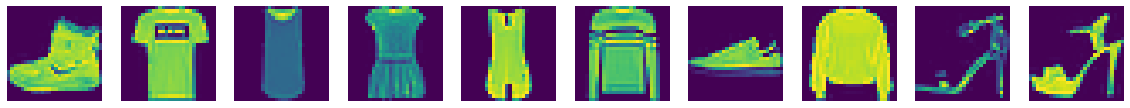

In [7]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,10, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(X_train_full[i], interpolation = 'nearest')
    if i == 9:
        break

In [8]:
# for simplicity, we scale pixel intensities down to the 0-1 range by dividing them by 255.0
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

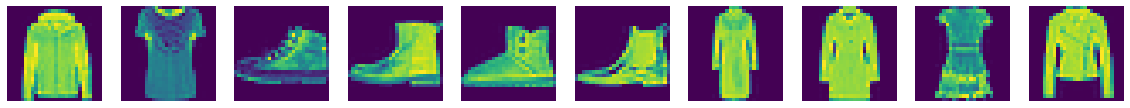

In [9]:
fig, axes = plt.subplots(1,10, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.set_axis_off()
    ax.imshow(X_train[i], interpolation = 'nearest')
    if i == 9:
        break

#note that scaling down pixel intensities does not prevent matplotlib from showing images

In [10]:
#y is categorical variable with categories 0-9
y_train, (min(y_train), max(y_train))

(array([4, 0, 7, ..., 3, 0, 5], dtype=uint8), (0, 9))

In [11]:
#MODEL
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [13]:
#All the parameters of a layer can be accessed using its get_weights() and set_weights() method. 
#For a Dense layer, this includes both the connection weights and the bias terms:
for lay in model.layers:
    print('Layer Name: '+str(lay.name))
    print('Layer Weights: '+str(lay.get_weights()))

Layer Name: flatten
Layer Weights: []
Layer Name: dense
Layer Weights: [array([[ 0.0256563 , -0.0686467 ,  0.05483866, ..., -0.06288424,
        -0.03398906, -0.03171182],
       [-0.04986566, -0.00509562, -0.06379122, ..., -0.07338349,
        -0.0433108 ,  0.00558533],
       [-0.02575299,  0.03582472,  0.05842446, ...,  0.04494151,
         0.01582589,  0.03678177],
       ...,
       [-0.05159576,  0.02305316, -0.06370226, ...,  0.05506557,
        -0.06384888,  0.03270869],
       [-0.04103502,  0.03714301,  0.04817211, ..., -0.04109614,
         0.0632505 , -0.07065772],
       [-0.01195702,  0.03766215,  0.04291759, ...,  0.0529993 ,
        -0.0343721 , -0.06279245]], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [14]:
#use compile method to specify optimizer and loss function
model.compile(loss="sparse_categorical_crossentropy",
                  optimizer="sgd",
                  metrics=["accuracy"])

In [15]:
#Call .fit() to train the model
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.7267 - accuracy: 0.7607 - val_loss: 0.5406 - val_accuracy: 0.8174
Epoch 2/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4901 - accuracy: 0.8297 - val_loss: 0.4465 - val_accuracy: 0.8478
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4463 - accuracy: 0.8429 - val_loss: 0.4339 - val_accuracy: 0.8474
Epoch 4/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4182 - accuracy: 0.8529 - val_loss: 0.4106 - val_accuracy: 0.8556
Epoch 5/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3988 - accuracy: 0.8591 - val_loss: 0.3868 - val_accuracy: 0.8654
Epoch 6/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3821 - accuracy: 0.8661 - val_loss: 0.3757 - val_accuracy: 0.8676
Epoch 7/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3684 - accuracy: 0.8694 - val_loss: 0.3684 - val_accuracy:

       loss  accuracy  val_loss  val_accuracy
0  0.726679  0.760691  0.540618        0.8174


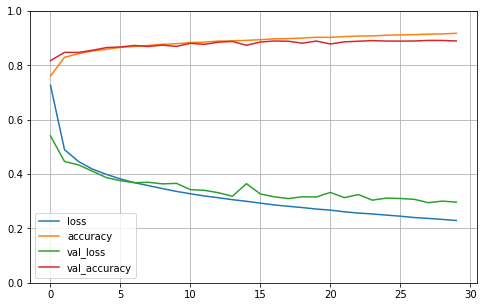

In [21]:
# The fit() method returns:
# a History object containing the training parameters (history.params), 
# the list of epochs it went through (history.epoch), 
# most importantly a dictionary (history.history) containing the loss and extra metrics 
#     it measured at the end of each epoch on the training set and on the validation set

import pandas as pd
print(pd.DataFrame(history.history).head(1)) #showing first row of history.history
pd.DataFrame(history.history).plot(figsize=(8, 5)) 
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
plt.show()

In [20]:
print(history.params)
print(history.epoch)
print(history.history.keys())

{'verbose': 1, 'epochs': 30, 'steps': 1719}
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [22]:
#evaluate model on test set
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 61.5081 - accuracy: 0.8538


[61.5080680847168, 0.8537999987602234]

In [23]:
# predict three test points
X_new = X_test[:10]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [25]:
y_test[:10]

array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7], dtype=uint8)

# Housing Dataset Regression

### Standard Network - a Sequential API

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#this dataset is simpler than the one from Ch2 - no missing data or categorical features
housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) #scale training data using mu, std of training data
X_valid = scaler.transform(X_valid) #scale validation data using mu, std of training data
X_test = scaler.transform(X_test) #scale testing data using mu, std of training data

In [3]:
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# initiate model
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])


model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3)) #specify loss and optimizer
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) #train model

mse_test = model.evaluate(X_test, y_test) #evaluate on test set

X_new = X_test[:3]
y_pred = model.predict(X_new) #evaluate on 3 examples from test set

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.6419 - val_loss: 0.8560
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.7047 - val_loss: 0.6531
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6345 - val_loss: 0.6099 - ETA: 0s - loss: 0.636
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5977 - val_loss: 0.5658
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5706 - val_loss: 0.5355
Epoch 6/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5472 - val_loss: 0.5173
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5288 - val_loss: 0.5081
Epoch 8/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5130 - val_loss: 0.4799
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4992 - val_loss: 0.4690
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0

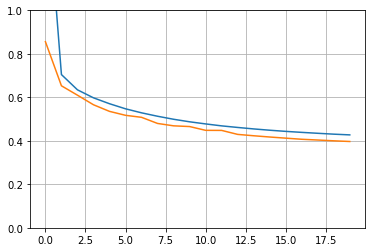

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

### Wide and Deep NN - a Functional API

The idea behind the wide and deep NN is to feed both the last hidden layer and the input layer to the output function to determine the output. By doing this, the network can use "deep" (last hidden layer) and "wide" (input layer) to determine long-range and short-range interactions (i.e. deep patterns and simple rules), respectively. We don't use the sequential module because it doesn't allow us to concatenate the input with the last hidden activations.

In [13]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2]) #concatenate last hidden layer with input
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [19]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3)) #specify loss and optimizer
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) #train model

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8772 - val_loss: 0.6913
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.6501 - val_loss: 0.9454
Epoch 3/20
363/363 [==============================] - 1s 2ms/step - loss: 0.6012 - val_loss: 0.6622
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5654 - val_loss: 0.5284
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5414 - val_loss: 0.5004
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5181 - val_loss: 0.5894
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5035 - val_loss: 0.5889
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4904 - val_loss: 0.4690
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4769 - val_loss: 0.5305
Epoch 10/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4676 - val_loss: 0.5466

### Subclass API - like Pytorch

In [30]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        
    def call(self, input_):
        hidden1 = self.hidden1(input_)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_, hidden2])
        main_output = self.main_output(concat)
        return main_output

model = WideAndDeepModel(30, activation="relu")

In [31]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3)) #specify loss and optimizer
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid)) #train model

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.8871 - val_loss: 0.9046
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6985 - val_loss: 1.2191
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6362 - val_loss: 0.6300
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5831 - val_loss: 0.5406
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5507 - val_loss: 0.5568
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5220 - val_loss: 0.5102
Epoch 7/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5009 - val_loss: 0.4646
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4829 - val_loss: 0.4541
Epoch 9/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4675 - val_loss: 0.4537
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4558 - val_loss: 0.4169

In [32]:
model.summary()

Model: "wide_and_deep_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             multiple                  270       
_________________________________________________________________
dense_14 (Dense)             multiple                  930       
_________________________________________________________________
dense_15 (Dense)             multiple                  39        
Total params: 1,239
Trainable params: 1,239
Non-trainable params: 0
_________________________________________________________________


### Using Callbacks for early stopping

In [38]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [35]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.9043 - val_loss: 1.0830
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7506 - val_loss: 0.6737
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6683 - val_loss: 0.6068
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6184 - val_loss: 0.5706
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5827 - val_loss: 0.5386
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5531 - val_loss: 0.5132
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5294 - val_loss: 0.4944
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5088 - val_loss: 0.4685
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4909 - val_loss: 0.4484
Epoch 10/10
162/162 [==============================] - 0s 1ms/step - loss: 0.4550


In [36]:
model.save("my_keras_model.h5")

In [40]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
log_csv = keras.callbacks.CSVLogger('my_logs.csv', separator = ',', append=False)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, log_csv])
mse_test = model.evaluate(X_test, y_test)

Epoch 1/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3771 - val_loss: 0.3830
Epoch 2/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3761 - val_loss: 0.4189
Epoch 3/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3754 - val_loss: 0.3857
Epoch 4/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3745 - val_loss: 0.3778
Epoch 5/100
363/363 [==============================] - 1s 4ms/step - loss: 0.3737 - val_loss: 0.3606
Epoch 6/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3727 - val_loss: 0.3827
Epoch 7/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3721 - val_loss: 0.3653
Epoch 8/100
363/363 [==============================] - 1s 3ms/step - loss: 0.3711 - val_loss: 0.3562
Epoch 9/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3704 - val_loss: 0.3667
Epoch 10/100
363/363 [==============================] - 1s 2ms/step - loss: 0.3696 - val_lo

### Tensorboard

In [50]:
import os
from tensorflow.keras.callbacks import TensorBoard
root_logdir = os.path.join(os.curdir, "my_logs")

In [51]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [52]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [53]:
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = get_run_logdir())
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Epoch 1/30
363/363 [==============================] - 1s 2ms/step - loss: 1.8866 - val_loss: 0.7126
Epoch 2/30
363/363 [==============================] - 1s 2ms/step - loss: 0.6577 - val_loss: 0.6880
Epoch 3/30
363/363 [==============================] - 1s 3ms/step - loss: 0.5934 - val_loss: 0.5803
Epoch 4/30
363/363 [==============================] - 1s 1ms/step - loss: 0.5557 - val_loss: 0.5166
Epoch 5/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5272 - val_loss: 0.4895
Epoch 6/30
363/363 [==============================] - 1s 2ms/step - loss: 0.5033 - val_loss: 0.4951
Epoch 7/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4854 - val_loss: 0.4861
Epoch 8/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4709 - val_loss: 0.4554
Epoch 9/30
363/363 [==============================] - 0s 1ms/step - loss: 0.4578 - val_loss: 0.4413
Epoch 10/30
363/363 [==============================] - 1s 2ms/step - loss: 0.4474 - val_loss: 0.4379